# In this dataset

1. does it match the statistics of a high dimensional grid representation
2. Is the taurus real
3. test whether you can do the grid realignment like carpenter also in the big maze
4. show that correlation structure is preserved only in as far as cells are spatial

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import re
import seaborn
import pandas as pd
#import cv2
import scipy.optimize as op
import sys
import networkx as nx
import time
import matplotlib
import copy as cp
import scipy.ndimage as ndi 

import scipy as sp
import scipy.signal
seaborn.set(style='ticks',font_scale=1.5)


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# These are the positions of the pokes
poke_pos = np.array([1,-1])*np.array([ [149,0],
                                 [68,19],[231,19],
                               [0,62],[149,62],[298,62],
                                 [68,105],[231,105],
                                      [149,124]])

# From pycontrol

In [3]:
from mecll.load import load_data
from mecll.process_data.proc_beh import get_all_transitions, get_transitions_state, build_poke_df, get_in_task_pokes
from mecll.process_data.proc_neural import get_all_resps, get_mean_resps
from mecll.plot.plot_activity_on_graph import plot_activity_on_graph, plot_cell

# Actual code

In [4]:
#Load behavioural data
root_path = '/Users/yves/team_mouse Dropbox/MEC_data/spike_sorted/2021-08-06_39964_ks25/'
#'/Users/yves/Downloads/example_files2_wOF//'

out = load_data(root_path)
spkT,spkC,single_units,events,lines,aligner = out

567 567


In [5]:
# process task data to get 
all_poke_dict = get_in_task_pokes(lines,events)

In [9]:
# all_poke_dict[0].keys()  # task 0
# all_poke_dict[1].keys()  # task 1

dict_keys(['task_nr', 'seq', 'graph_type', '7', '5', '2', '3', '8', '1', '0', '4', '6'])

In [11]:
# build a big dataframe that stores stuff about each poke
df = build_poke_df(lines,events)
df['previous_port'][1:] = df['port'][:-1]
df['previous_state'][1:] = df['state'][:-1]

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
# This can then be used for filtering as is crudely done here.
# Sure there is some pandas magic that can be applied to do this
poke_dict_t1 ={}
poke_dict_t2 = {}
for port_nr in np.unique(df['port'].values):
    for task_nr in range(2):
        task_nr = str(task_nr)
        v = df.loc[(df['port']==port_nr) &
                   (df['correct']==True) & 
                   #(df['next_correct']==True) &
                   #(df['reward']==True) &
                   #(df['port_repeat']==False) & 
                   #(df['RT']<1600) &
                   (df['task_nr']==task_nr)
                  ]['time'].values
        #v = np.array(v).astype('float')
        if task_nr=='0':
            print(task_nr,len(v),str(port_nr))
            poke_dict_t1[str(port_nr)] = [float(i) for i in v]
        else:
            poke_dict_t2[str(port_nr)] = [float(i) for i in v]
            
        # this is flagged separately as this is the last port
        # that is looked at and at this point puut relevant details into the poke dicts
        if port_nr==8:
            poke_dict_t1['task_nr'] = str(task_nr)
            poke_dict_t2['task_nr'] = str(task_nr)
            poke_dict_t1['graph_type'] = df.loc[df['task_nr']==task_nr]['graph_type'].values[0]
            poke_dict_t2['graph_type'] = df.loc[df['task_nr']==task_nr]['graph_type'].values[0]
            poke_dict_t1['seq'] = df.loc[df['task_nr']==task_nr]['current_sequence'].values[0]
            poke_dict_t2['seq'] = df.loc[df['task_nr']==task_nr]['current_sequence'].values[0]

0 16 0
0 50 1
0 36 2
0 35 3
0 45 4
0 24 5
0 28 6
0 41 7
0 26 8


In [10]:
tmp_ = get_all_resps(aligner,poke_dict_t1,single_units,spkT,spkC,window0=6000,window1=6000)
all_resps_g1_single_trial, (all_resps1_g1_single_trial,all_resps2_g1_single_trial)  = tmp_
tmp_ = get_all_resps(aligner,poke_dict_t2,single_units,spkT,spkC,window0=6000,window1=6000)
all_resps_g2_single_trial, (all_resps1_g2_single_trial,all_resps2_g2_single_trial) = tmp_

In [11]:
len(single_units)

201

In [12]:
def get_mean_resps(all_resps_single_trial):
    mus = []
    vs = []
    mu_g1 = []
    var_g1 = []
    for neuron in all_resps_single_trial:
        tmp_mu = []
        tmp_var = []
        for poke in neuron:
            tmp_mu.append(np.mean(poke))
            tmp_var.append(np.var(poke))
        mu_g1.append(tmp_mu)
        var_g1.append(tmp_var)

    return np.array(mu_g1),np.array(var_g1)

In [13]:
all_resps_g1,_ = get_mean_resps(all_resps_g1_single_trial)
all_resps_g2,_ = get_mean_resps(all_resps_g2_single_trial)


all_resps1_g1,_ = get_mean_resps(all_resps1_g1_single_trial)
all_resps1_g2,_ = get_mean_resps(all_resps1_g2_single_trial)

all_resps2_g1,_ = get_mean_resps(all_resps2_g1_single_trial)
all_resps2_g2,_ = get_mean_resps(all_resps2_g2_single_trial)

In [14]:
from sklearn.decomposition import pca

In [15]:
#
ccs_within1 = []
for r1,r2 in zip(all_resps1_g1,all_resps2_g1):
    ccs_within1.append(np.corrcoef(r1,r2)[0,1])
    
ccs_within1 = np.array(ccs_within1)
print(np.nanmean(ccs_within1))

0.5807073208971512


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [16]:
#
ccs_within2 = []
for r1,r2 in zip(all_resps1_g1,all_resps2_g1):
    ccs_within2.append(np.corrcoef(r1,r2))
    
ccs_within2 = np.array(ccs_within2)
print(np.nanmean(ccs_within2))

0.7936813801239949


In [17]:

#ax = seaborn.jointplot(ccs_within1,ccs_within2)
#ax.ax_joint.plot([-1,1],[-1,1])

#plt.ylim(-1,1)
#plt.xlim(-1,1)

In [18]:
from scipy.stats import spearmanr


In [19]:
spearmanr(all_resps1_g1[0],all_resps1_g2[0])

SpearmanrResult(correlation=-0.25, pvalue=0.5164895523012263)

In [20]:
ix = 1
np.corrcoef(all_resps1_g1[0],all_resps1_g2[1])

array([[1.        , 0.35555267],
       [0.35555267, 1.        ]])

In [21]:
#
ccs_within2 = []
for r1,r2 in zip(all_resps1_g2,all_resps2_g2):
    ccs_within2.append(np.corrcoef(r1,r2)[0,1])
ccs_within2 = np.array(ccs_within2)

print(np.nanmean(ccs_within2))

0.5817864246375465


In [22]:
ccs_both = np.vstack([ccs_within1,ccs_within2])

In [23]:
ccs_within = (np.array(ccs_within1) + np.array(ccs_within2))/2.
ccs_within = np.min(np.vstack([np.array(ccs_within1),np.array(ccs_within2)]),axis=0)

In [24]:
#
ccs_across = []
for r1,r2 in zip(all_resps_g1,all_resps_g2):
    ccs_across.append(np.corrcoef(r1,r2)[0,1])
    
ccs_across = np.array(ccs_across)
print(np.nanmean(ccs_across))

0.5923544305807923


Text(0, 0.5, 'within_task2 stability')

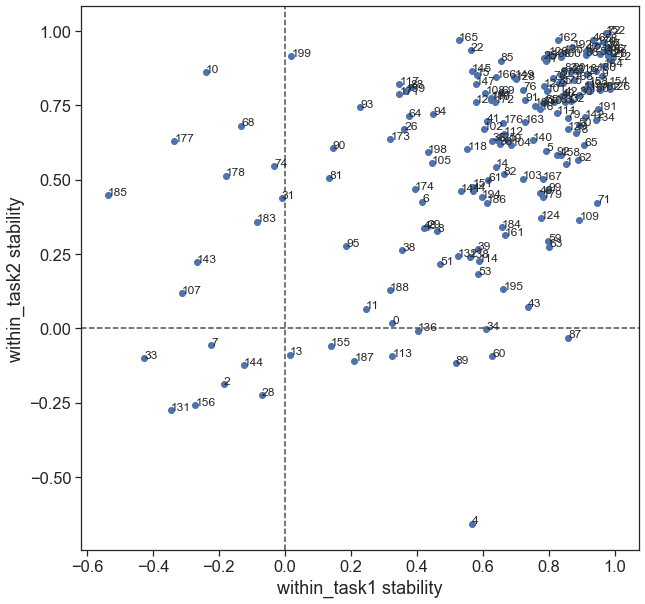

In [25]:
plt.figure(figsize=(10,10))
plt.scatter(ccs_within1,ccs_within2)
plt.axvline(x=0,color='.3',linestyle='--')
plt.axhline(y=0,color='.3',linestyle='--')
for i, txt in enumerate(ccs_across):
    plt.gca().annotate(i, (ccs_within1[i], ccs_within2[i]),fontsize=12)

plt.xlabel('within_task1 stability')
plt.ylabel('within_task2 stability')

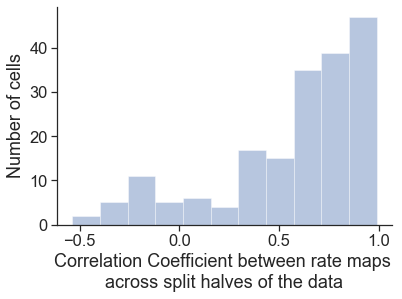

In [26]:
seaborn.distplot(np.array(ccs_within1)[np.isfinite(ccs_within1)],kde=0)
plt.xlabel("Correlation Coefficient between rate maps \nacross split halves of the data")
plt.ylabel("Number of cells")
seaborn.despine()

Text(0.5, 0, 'Mean firing rate')

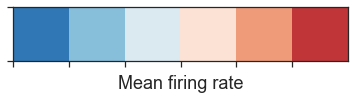

In [27]:
seaborn.palplot(seaborn.color_palette('RdBu_r'),)
plt.xlabel('Mean firing rate')

Text(0, 0.5, 'within_task_stability')

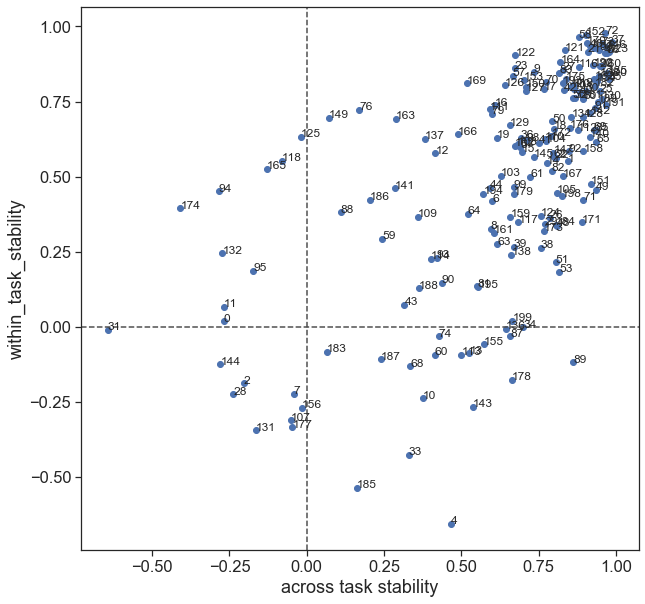

In [28]:
plt.figure(figsize=(10,10))
plt.scatter(ccs_across,ccs_within)
plt.axvline(x=0,color='.3',linestyle='--')
plt.axhline(y=0,color='.3',linestyle='--')
for i, txt in enumerate(ccs_across):
    plt.gca().annotate(i, (ccs_across[i], ccs_within[i]),fontsize=12)

plt.xlabel('across task stability')
plt.ylabel('within_task_stability')

In [29]:
#plot_cell(28,all_resps_g1,all_resps_g2,all_poke_dict,norm=True,norm_pct=99)

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


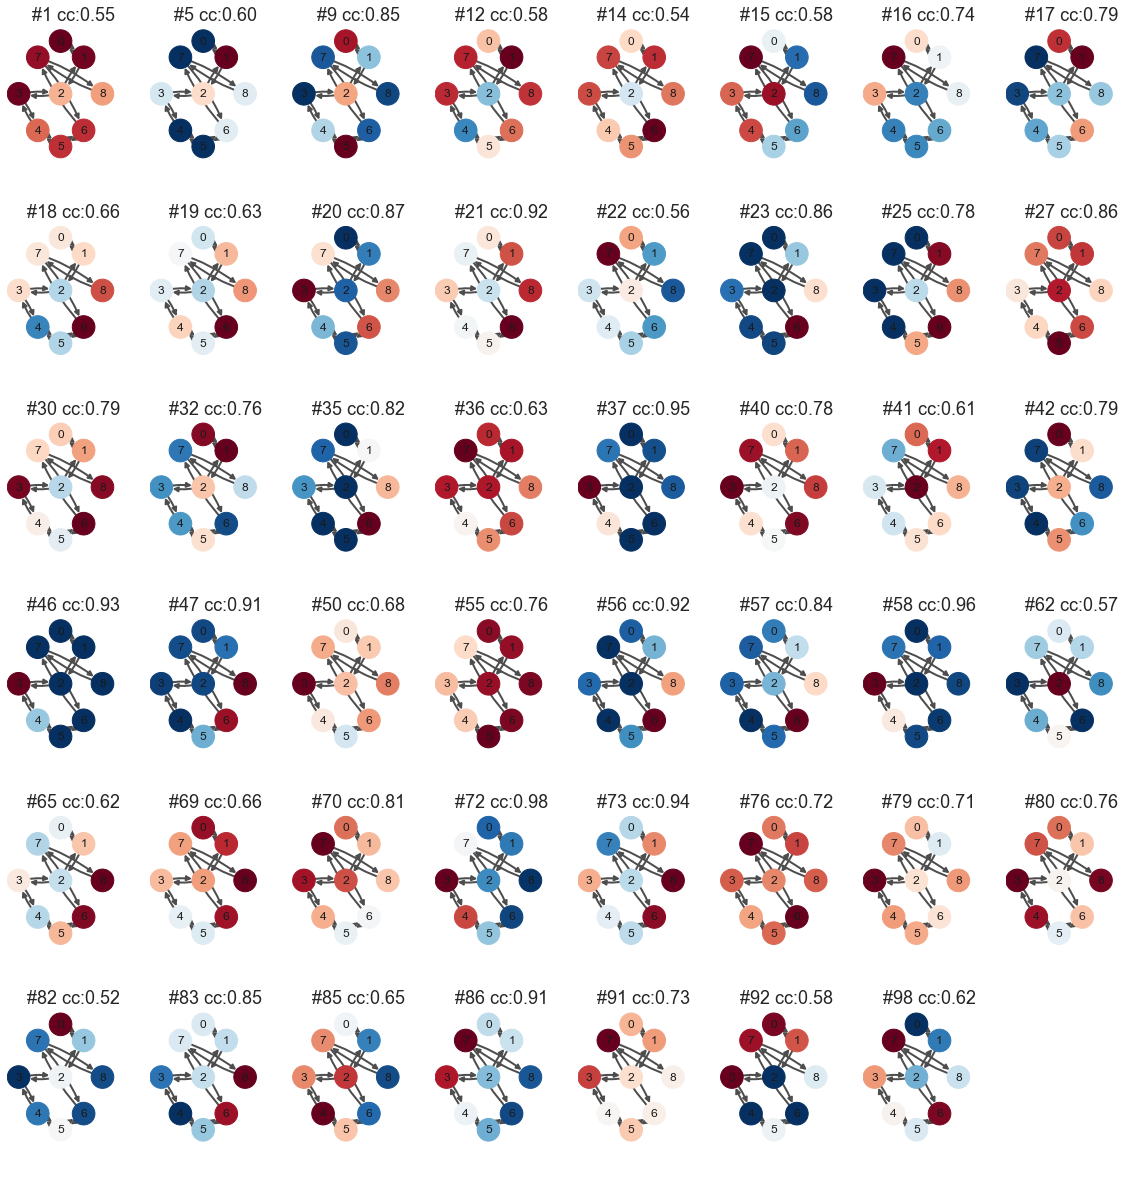

In [61]:
plt.figure(figsize=(16,22))
ctr = 0
for ctr_,spks in enumerate(all_resps1_g2[:100]):
    if ccs_within[ctr_]>0.5:
        plt.subplot(8,8,ctr+1)
        plt.title('#'+str(ctr_) + ' cc:' + '{:.2f}'.format(ccs_within[ctr_]))
        #nx.draw_circular(G,node_color=spks,node_size=512)
        plot_activity_on_graph(all_poke_dict[0]['seq'],'line',spks=spks,order='poke',node_size=512)
        axis = plt.gca()
        # maybe smaller factors work as well, but 1.1 works fine for this minimal example
        axis.set_xlim([1.3*x for x in axis.get_xlim()])
        axis.set_ylim([1.3*y for y in axis.get_ylim()])
        ctr+= 1

plt.tight_layout()

In [62]:
all_resps_g1.shape

(201, 9)

In [63]:
all_resps_g2.shape

(201, 9)

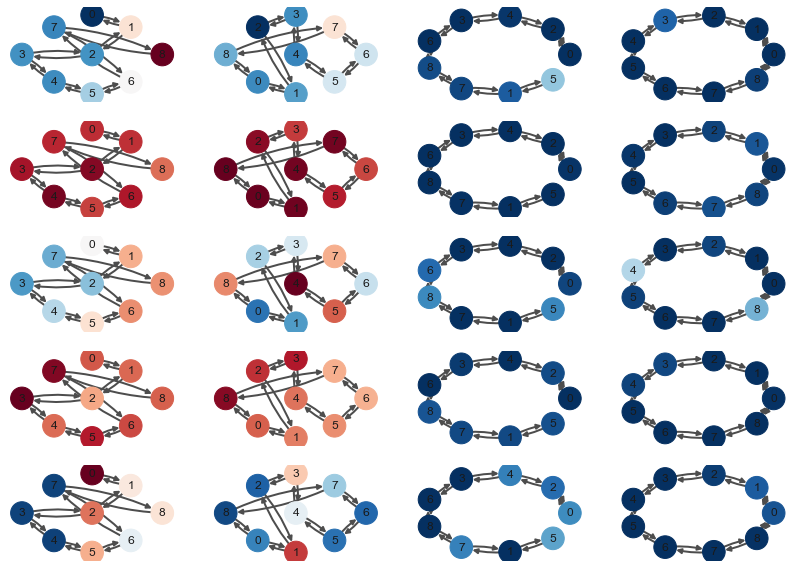

In [33]:
mean_resps_state = (all_resps_g1 + all_resps_g2)/2.

resps_state_g1 = (all_resps_g1-mean_resps_state)[:,all_poke_dict[0]['seq']]
resps_state_g2 = (all_resps_g2-mean_resps_state)[:,all_poke_dict[1]['seq']]
plt.figure(figsize=(14,84))

n_plot = 40
start = 0
ctr = 0
for i in range(5,10):#len(ccs_within)):
    if True:#ccs_within[i]>0.3 and ccs_across[i]<0.6:
        spks1 = all_resps_g1[i]# - ( all_resps_g1[i]+ all_resps_g2[i])/2.
        spks2 = all_resps_g2[i]# - ( all_resps_g1[i]+ all_resps_g2[i])/2.
        mx = np.nanmax(np.concatenate([spks1,spks2]))
        mn = 0#np.nanmin(np.concatenate([spks1,spks2]))
        plt.subplot(n_plot,4,4*ctr+1)
        #plt.title('Cell:{} |  ccs_across:{:.2f}'.format(i,ccs_across[i]))

        spks = spks1
        plot_activity_on_graph(all_poke_dict[0]['seq'],all_poke_dict[0]['graph_type'],
                               spks=spks,order='poke',mx=mx,mn=mn)
        
        plt.subplot(n_plot,4,4*ctr+2)
        spks = spks2
        plot_activity_on_graph(all_poke_dict[1]['seq'],all_poke_dict[1]['graph_type'],
                               spks=spks,order='poke',mx=mx,mn=mn)

        plt.subplot(n_plot,4,4*ctr+3)
        spks = resps_state_g1[i]
        plot_activity_on_graph(all_poke_dict[0]['seq'],all_poke_dict[0]['graph_type'],
                               spks=spks,order='state',mx=mx,mn=mn)
        
        plt.subplot(n_plot,4,4*ctr+4)
        spks = resps_state_g2[i]
        plot_activity_on_graph(np.arange(9).tolist(),all_poke_dict[1]['graph_type'],
                               spks=spks,order='state',mx=mx,mn=mn)

        ctr +=1

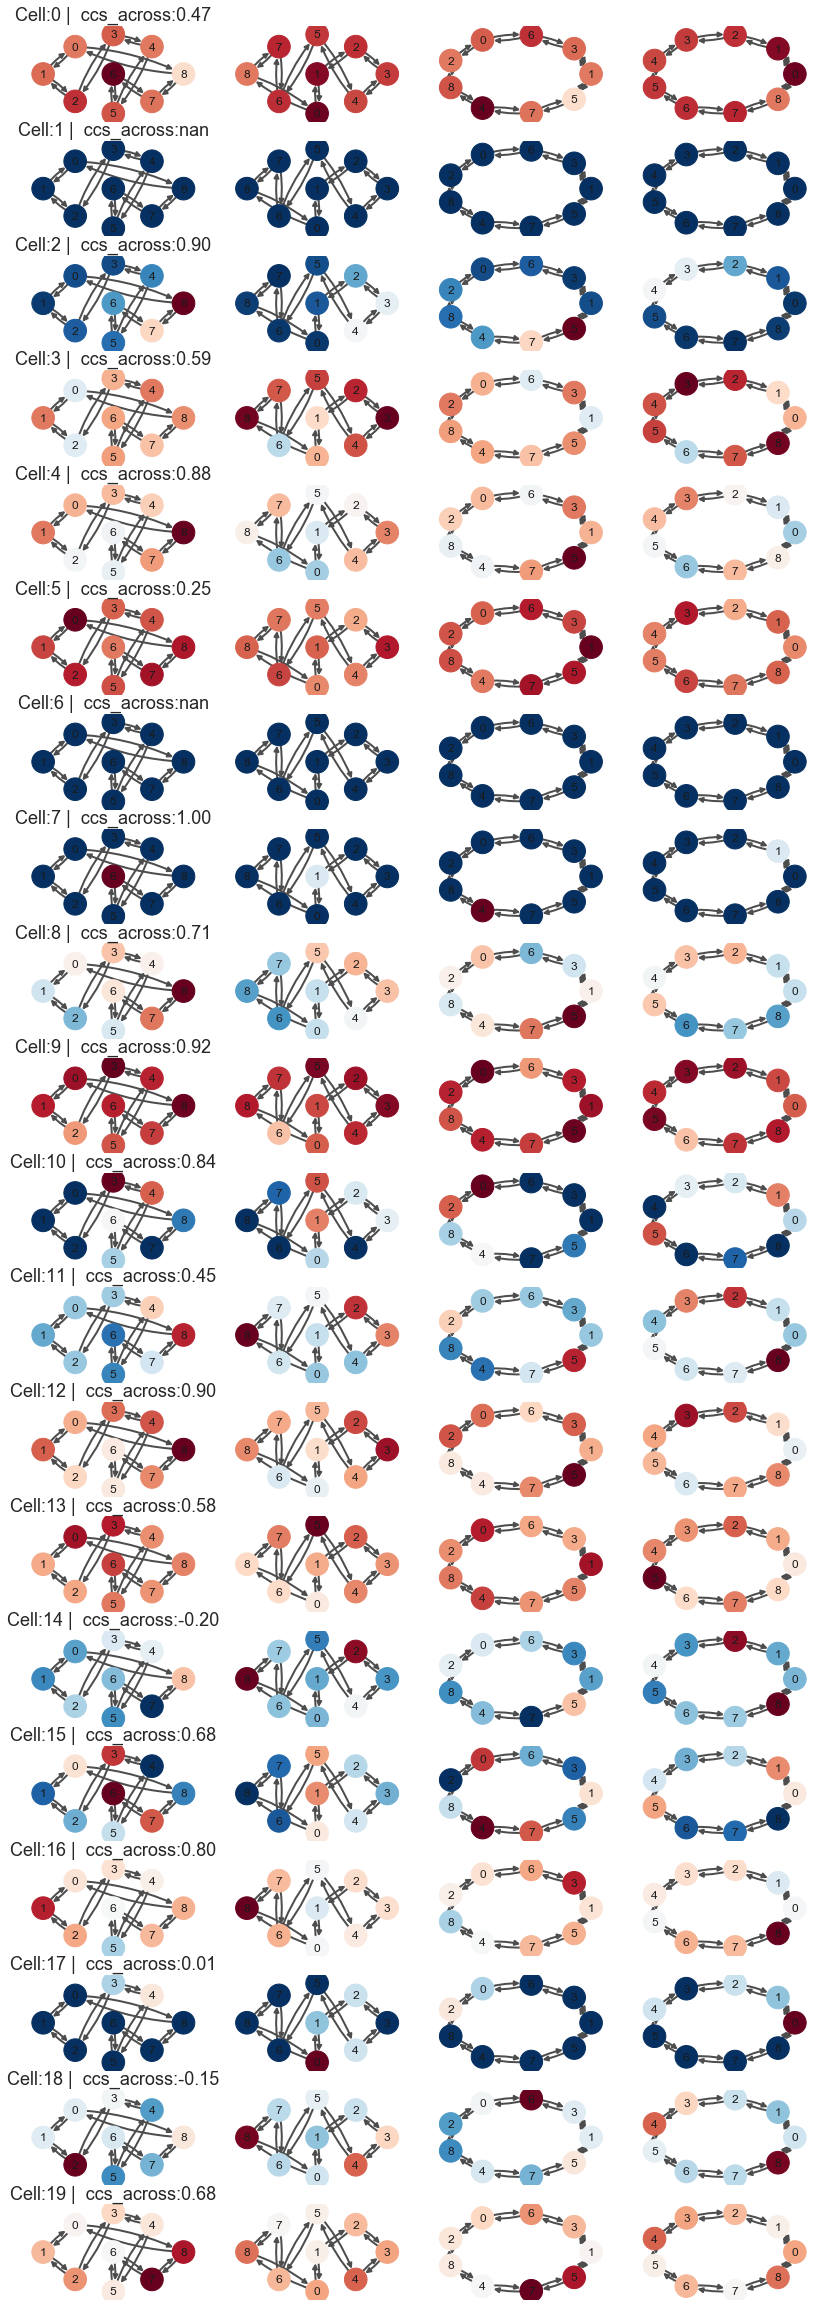

In [34]:
resps_state_g1 = all_resps_g1[:,all_poke_dict[0]['seq']]
resps_state_g2 = all_resps_g2[:,all_poke_dict[1]['seq']]
plt.figure(figsize=(14,84))

n_plot = 40
start = 0
ctr = 0
for i in range(20):#len(ccs_within)):
    if True:#ccs_within[i]>0.3 and ccs_across[i]<0.6:
        spks1 = all_resps_g1[i]# - ( all_resps_g1[i]+ all_resps_g2[i])/2.
        spks2 = all_resps_g2[i]# - ( all_resps_g1[i]+ all_resps_g2[i])/2.
        mx = np.nanmax(np.concatenate([spks1,spks2]))
        mn = 0#np.nanmin(np.concatenate([spks1,spks2]))
        plt.subplot(n_plot,4,4*ctr+1)
        plt.title('Cell:{} |  ccs_across:{:.2f}'.format(i,ccs_across[i]))

        spks = spks1
        plot_activity_on_graph(all_poke_dict[0]['seq'],all_poke_dict[0]['graph_type'],
                               spks=spks,order='poke',mx=mx,mn=mn)
        
        plt.subplot(n_plot,4,4*ctr+2)
        spks = spks2
        plot_activity_on_graph(all_poke_dict[1]['seq'],all_poke_dict[1]['graph_type'],
                               spks=spks,order='poke',mx=mx,mn=mn)

        plt.subplot(n_plot,4,4*ctr+3)
        spks = resps_state_g1[i]
        plot_activity_on_graph(all_poke_dict[0]['seq'],all_poke_dict[0]['graph_type'],
                               spks=spks,order='state',mx=mx,mn=mn)
        
        plt.subplot(n_plot,4,4*ctr+4)
        spks = resps_state_g2[i]
        plot_activity_on_graph(np.arange(9).tolist(),all_poke_dict[1]['graph_type'],
                               spks=spks,order='state',mx=mx,mn=mn)

        ctr +=1

In [179]:
import scipy.stats as stt

In [34]:
stt.ttest_ind(ccs_across[np.isfinite(ccs_across)],ccs_across[[148,132,134,113,123,267,275]])

IndexError: index 267 is out of bounds for axis 0 with size 201

ValueError: cannot convert float NaN to integer

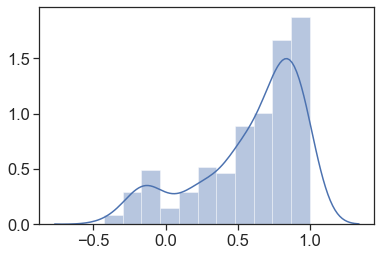

In [78]:
seaborn.distplot(ccs_across[np.isfinite(ccs_across)],kde=1)
seaborn.distplot(ccs_across[[148,132,134,113,123,267,275]],kde=1)

In [113]:
len([ 36,  78,  84,  99, 113, 115, 116, 117, 132, 133, 140, 148,
       220, 258, 265, 270, 274, 275, 312])

19

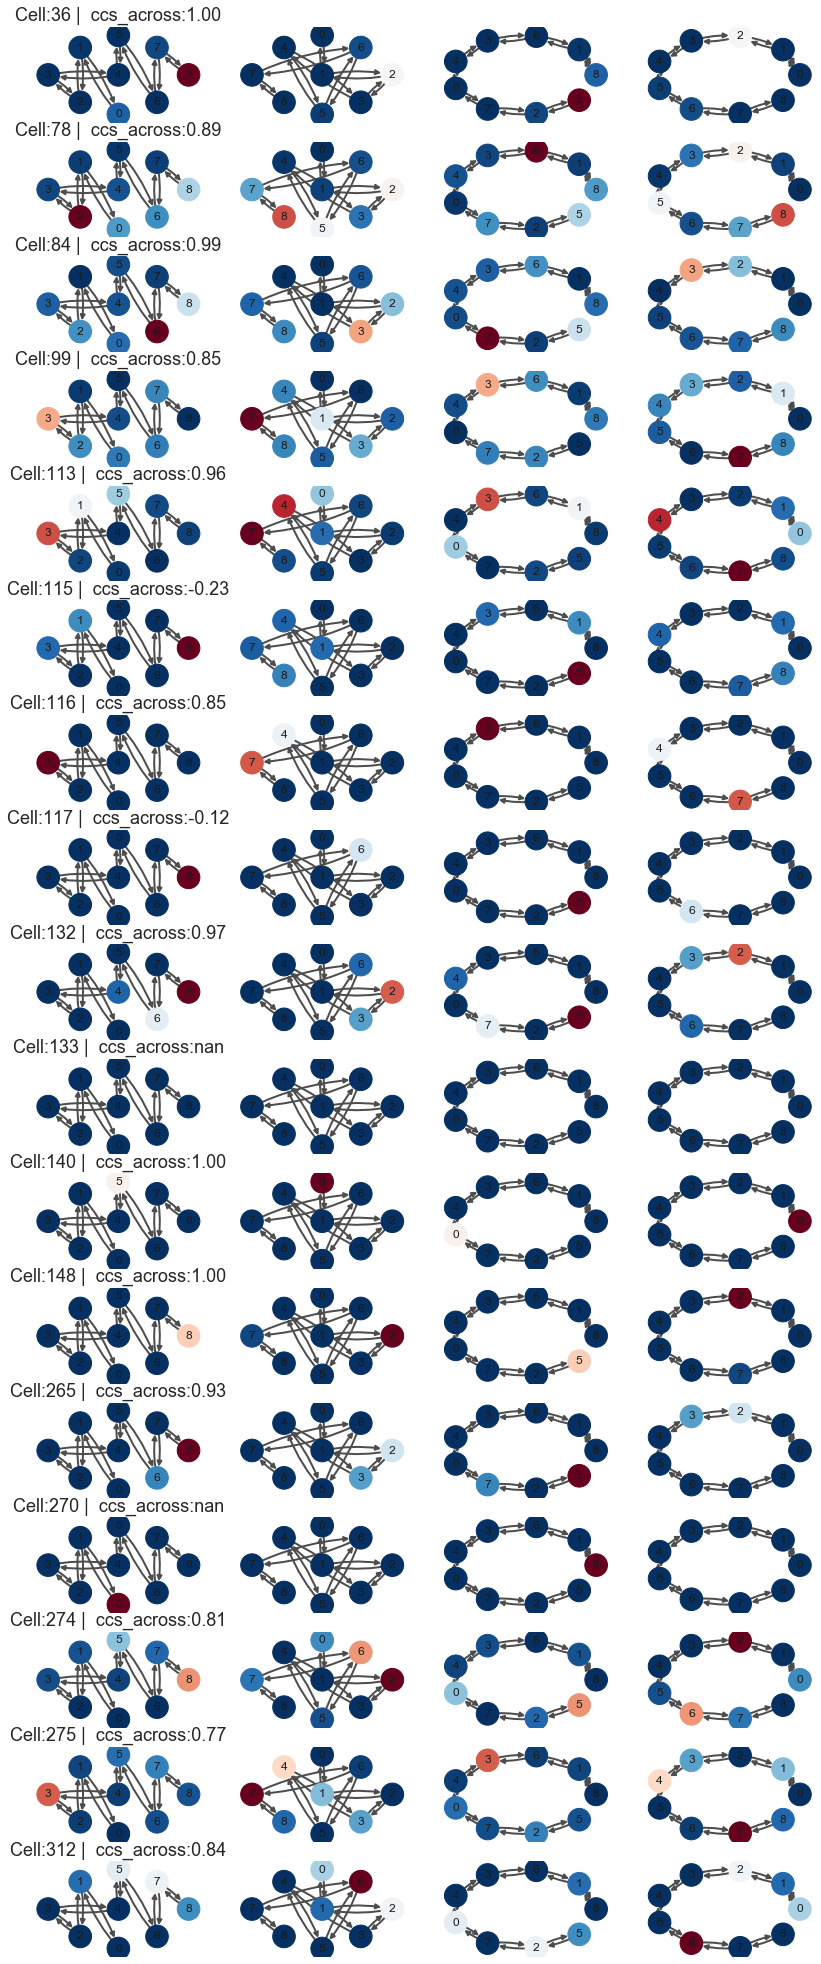

In [115]:
resps_state_g1 = all_resps_g1[:,all_poke_dict[0]['seq']]
resps_state_g2 = all_resps_g2[:,all_poke_dict[1]['seq']]
plt.figure(figsize=(14,84))

n_plot = 40
start = 0
ctr = 0
for i in [ 36,  78,  84,  99, 113, 115, 116, 117, 132, 133, 140, 148,
       265, 270, 274, 275, 312]:#range(len(ccs_within)):
    if True:#ccs_within[i]>0.3 and ccs_across[i]<0.6:
        spks1 = all_resps_g1[i]# - ( all_resps_g1[i]+ all_resps_g2[i])/2.
        spks2 = all_resps_g2[i]# - ( all_resps_g1[i]+ all_resps_g2[i])/2.
        mx = np.nanmax(np.concatenate([spks1,spks2]))
        mn = 0#np.nanmin(np.concatenate([spks1,spks2]))
        plt.subplot(n_plot,4,4*ctr+1)
        plt.title('Cell:{} |  ccs_across:{:.2f}'.format(i,ccs_across[i]))

        spks = spks1
        plot_activity_on_graph(all_poke_dict[0]['seq'],all_poke_dict[0]['graph_type'],
                               spks=spks,order='poke',mx=mx,mn=mn)
        
        plt.subplot(n_plot,4,4*ctr+2)
        spks = spks2
        plot_activity_on_graph(all_poke_dict[1]['seq'],all_poke_dict[1]['graph_type'],
                               spks=spks,order='poke',mx=mx,mn=mn)

        plt.subplot(n_plot,4,4*ctr+3)
        spks = resps_state_g1[i]
        plot_activity_on_graph(all_poke_dict[0]['seq'],all_poke_dict[0]['graph_type'],
                               spks=spks,order='state',mx=mx,mn=mn)
        
        plt.subplot(n_plot,4,4*ctr+4)
        spks = resps_state_g2[i]
        plot_activity_on_graph(np.arange(9).tolist(),all_poke_dict[1]['graph_type'],
                               spks=spks,order='state',mx=mx,mn=mn)

        ctr +=1